In [375]:
!pip install tensorflow

In [376]:
!pip install lightgbm

In [377]:
!pip install graphviz

In [378]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
import random
import numpy as np
from lightgbm import LGBMClassifier, plot_tree, LGBMRegressor
import seaborn as sbn

In [379]:
churned_color = "#E83F6F"
not_churned_color = "#2274A5"


# Generate a seed used in any random operation to allow reproducability
seed = random.randint(0, 2 << 31)
print(f"Random Seed: {seed}")

Random Seed: 2536045810


In [380]:
data_url = "https://raw.githubusercontent.com/ray33ee/bank-churn-analysis/main/merged.csv"

In [381]:
df = pd.read_csv(data_url, header=0)

In [382]:
df.head()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,Churned,France,Germany,Spain,Female,Male
0,668,33,3,0.00,2,1,0,181449.97,0,1,0,0,0,1
1,627,33,1,0.00,2,1,1,49503.50,0,1,0,0,0,1
2,678,40,10,0.00,2,1,0,184866.69,0,1,0,0,0,1
3,581,34,2,148882.54,1,1,1,84560.88,0,1,0,0,0,1
4,716,33,5,0.00,2,1,1,15068.83,0,0,0,1,0,1


In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185021 entries, 0 to 185020
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Credit Score      185021 non-null  int64  
 1   Age               185021 non-null  int64  
 2   Tenure            185021 non-null  int64  
 3   Account Balance   185021 non-null  float64
 4   No. of products   185021 non-null  int64  
 5   Has Credit Card   185021 non-null  int64  
 6   Is Active Member  185021 non-null  int64  
 7   Estimated Salary  185021 non-null  float64
 8   Churned           185021 non-null  int64  
 9   France            185021 non-null  int64  
 10  Germany           185021 non-null  int64  
 11  Spain             185021 non-null  int64  
 12  Female            185021 non-null  int64  
 13  Male              185021 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 19.8 MB


In [384]:
df.isnull().sum()

Credit Score        0
Age                 0
Tenure              0
Account Balance     0
No. of products     0
Has Credit Card     0
Is Active Member    0
Estimated Salary    0
Churned             0
France              0
Germany             0
Spain               0
Female              0
Male                0
dtype: int64

In [385]:
df.describe()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,Churned,France,Germany,Spain,Female,Male
count,185021.000000,185021.000000,185021.000000,185021.000000,185021.000000,185021.00000,185021.000000,185021.000000,185021.000000,185021.000000,185021.000000,185021.00000,185021.000000,185021.000000
mean,655.810978,38.211889,5.019565,57747.369724,1.551835,0.74872,0.499641,111226.810629,0.210754,0.536274,0.200588,0.20909,0.413050,0.532902
std,82.071139,9.059775,2.815592,63109.771556,0.551039,0.43375,0.500001,51267.835902,0.407845,0.498684,0.400441,0.40666,0.492383,0.498918
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,72496.050000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.00000,0.000000,116160.040000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000
75%,711.000000,43.000000,7.000000,121151.050000,2.000000,1.00000,1.000000,154189.080000,0.000000,1.000000,0.000000,0.00000,1.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [386]:
# When using head we want to remove any bias based on order, so here we shuffle the dataframe
df = shuffle(df, random_state=seed)

In [387]:
# Note: This function modifies 'data_frame' in place
def detect_outliers(data_frame, column):
    multiplier = 1.5
    q1 = data_frame[column].quantile(0.25)
    q3 = data_frame[column].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + iqr * multiplier
    lower = q1 - iqr * multiplier
    outliers_frames = data_frame.loc[(data_frame[column] < lower) | (data_frame[column] > upper)]
    indices = outliers_frames.index.values
    data_frame.drop(indices, inplace=True)
    print(f"Found and removed {len(indices)} outliers in column '{column}'")

columns_to_check = ["Credit Score", "Age", "Account Balance", "Estimated Salary"]

for c in columns_to_check:
    detect_outliers(df, c)


Found and removed 359 outliers in column 'Credit Score'
Found and removed 5780 outliers in column 'Age'
Found and removed 0 outliers in column 'Account Balance'
Found and removed 0 outliers in column 'Estimated Salary'


In [388]:
df.describe()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,Churned,France,Germany,Spain,Female,Male
count,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000,178882.000000
mean,656.253793,37.336166,5.022110,57624.768095,1.553426,0.749080,0.491995,111397.887636,0.206482,0.537533,0.200803,0.209076,0.412635,0.534777
std,81.250997,7.714966,2.813576,63099.757110,0.549433,0.433544,0.499937,51204.855452,0.404782,0.498591,0.400602,0.406650,0.492310,0.498790
min,426.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,72861.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116537.145000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,711.000000,42.000000,7.000000,121063.900000,2.000000,1.000000,1.000000,154393.965000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,850.000000,59.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [389]:
# Split the data into two groups, the customers that have churned and ones that have not
churned_group = df.groupby(df["Churned"])
has_churned = churned_group.get_group(1)
not_churned = churned_group.get_group(0)

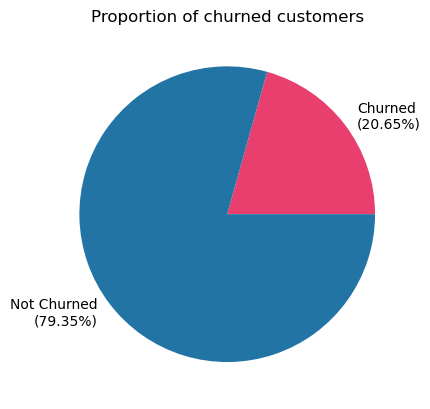

In [390]:
total_rows = len(df.index)
total_has_churned = len(has_churned.index)
churn_percentage = float(total_has_churned) / float(total_rows) * 100.0
ps = np.array([churn_percentage, 100.0 - churn_percentage])
plt.pie(ps, 
        labels=[f"Churned\n({churn_percentage:.2f}%)", f"Not Churned\n({100-churn_percentage:.2f}%)"], 
        colors=[churned_color, not_churned_color])
plt.title("Proportion of churned customers")
plt.show()

In [391]:
# Todo: add legend to plot
def plot_dual_histogram(column, title, xlabel, ylabel):
    fig, a = plt.subplots(2)
    plt.suptitle(title)
    a[0].hist(not_churned[column], color=not_churned_color)
    a[0].set_xlabel(xlabel)
    a[0].set_ylabel(ylabel)
    a[1].hist(has_churned[column], color=churned_color)
    a[1].set_xlabel(xlabel)
    a[1].set_ylabel(ylabel)
    fig.legend(["Not churned", "Churned"], bbox_to_anchor=[1.22, 0.9])
    fig.tight_layout()
    plt.show()

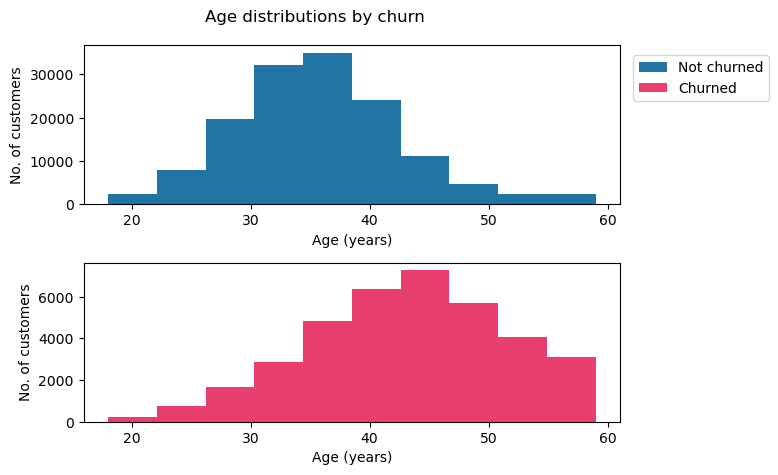

In [392]:
plot_dual_histogram("Age", "Age distributions by churn", "Age (years)", "No. of customers")

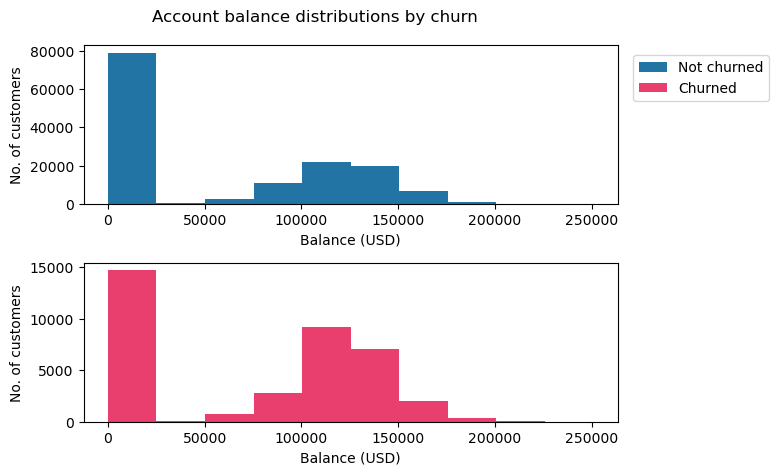

In [393]:
plot_dual_histogram("Account Balance", "Account balance distributions by churn", "Balance (USD)", "No. of customers")

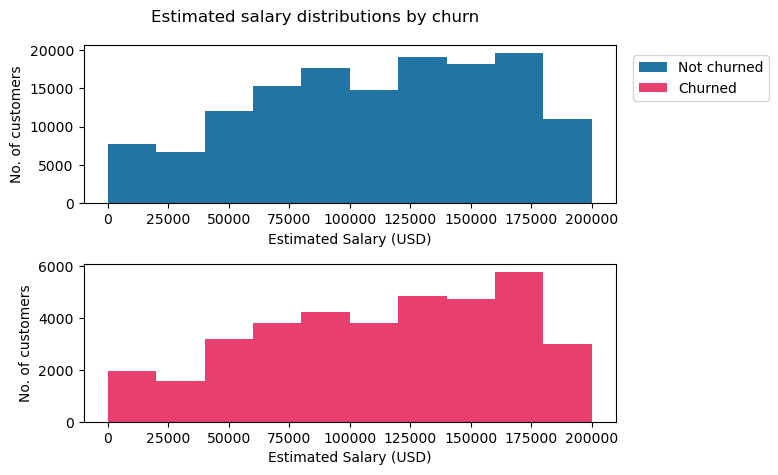

In [394]:
plot_dual_histogram("Estimated Salary", "Estimated salary distributions by churn", "Estimated Salary (USD)", "No. of customers")

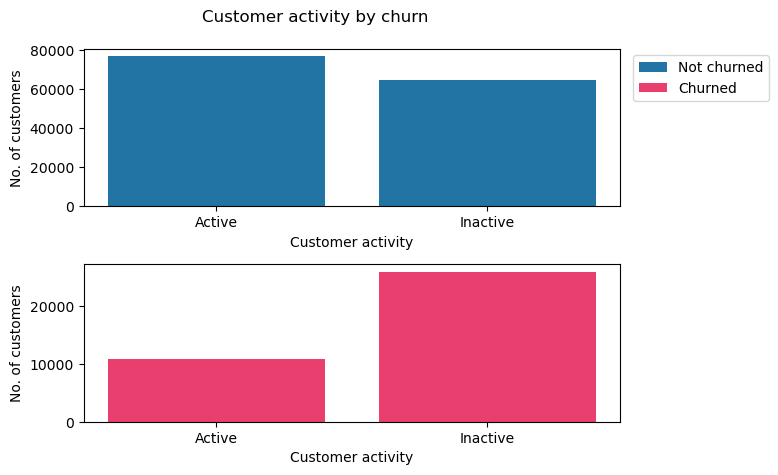

In [395]:
# Todo: color the histograms, label axis, label each plot and title 
fig, a = plt.subplots(2)

plt.suptitle("Customer activity by churn")

a[0].bar(["Active", "Inactive"], [not_churned["Is Active Member"].value_counts()[1], not_churned["Is Active Member"].value_counts()[0]], color=not_churned_color)
a[0].set_xlabel("Customer activity")
a[0].set_ylabel("No. of customers")

a[1].bar(["Active", "Inactive"], [has_churned["Is Active Member"].value_counts()[1], has_churned["Is Active Member"].value_counts()[0]], color=churned_color)
a[1].set_xlabel("Customer activity")
a[1].set_ylabel("No. of customers")
fig.legend(["Not churned", "Churned"], bbox_to_anchor=[1.22, 0.9])
fig.tight_layout()
plt.show()

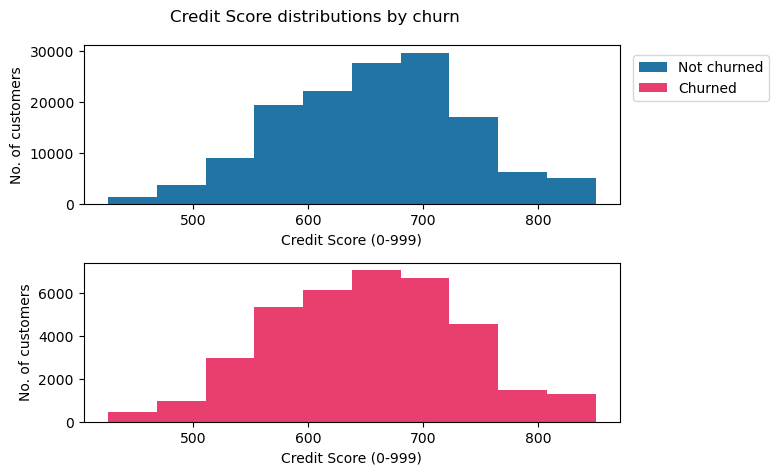

In [396]:
plot_dual_histogram("Credit Score", "Credit Score distributions by churn", "Credit Score (0-999)", "No. of customers")

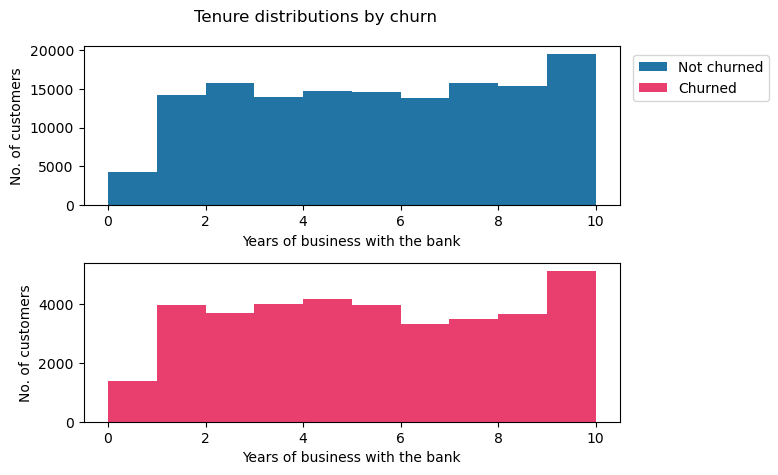

In [397]:
plot_dual_histogram("Tenure", "Tenure distributions by churn", "Years of business with the bank", "No. of customers")

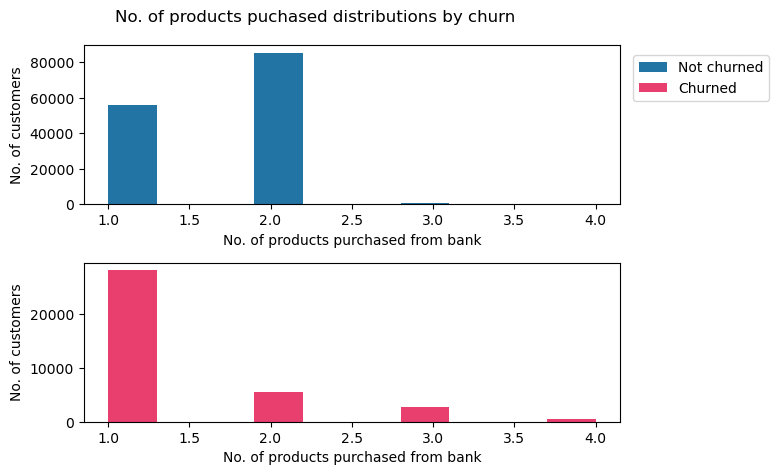

In [398]:
plot_dual_histogram("No. of products", "No. of products puchased distributions by churn", "No. of products purchased from bank", "No. of customers")

Text(0.5, 1.0, 'Correlation matrix over non-categorical features')

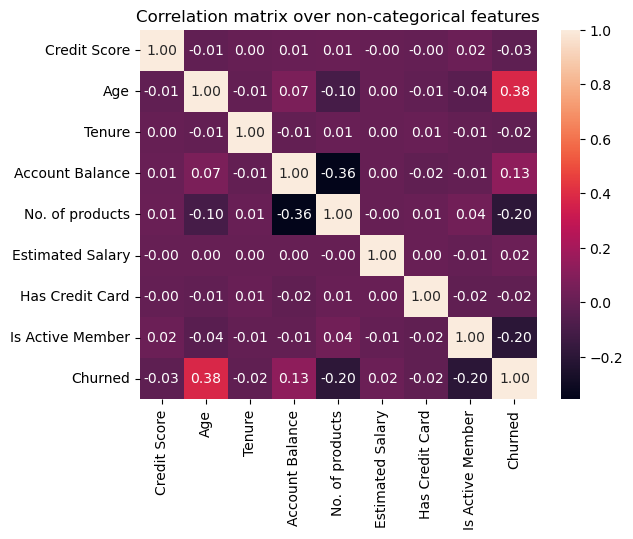

In [399]:
columns = ["Credit Score", "Age", "Tenure", "Account Balance", "No. of products", "Estimated Salary", "Has Credit Card", "Is Active Member", "Churned"]
cm = df[columns].corr()
sbn.heatmap(cm, annot=True, fmt=".2f").set_title("Correlation matrix over non-categorical features")

In [400]:
target = "Churned"

has_churned = churned_group.get_group(1)
not_churned = churned_group.get_group(0)

# Balance the dataset so the number of churned equals the number of not churned
#has_churned_size = len(has_churned.index)
#not_churned = not_churned.head(has_churned_size)
#df = pd.concat([has_churned, not_churned])

X = df.drop(target, axis=1)
y = df[target]

# The following code can be used to selectively normalise certain columns. However PCA requires all data to be normalised
def normalise_column(column, data_frame):
    if column in data_frame:
        data_frame[column] = (data_frame[column] - data_frame[column].mean()) / data_frame[column].std()

columns_to_normalise = df.columns.values #["Age", "Credit Score", "Tenure", "Account Balance", "No. of products", "Estimated Salary"]
 
for c in columns_to_normalise:
    normalise_column(c, X)


In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
X_train.describe()

,Credit Score,Age,Tenure,Account Balance,No. of products,Has Credit Card,Is Active Member,Estimated Salary,France,Germany,Spain,Female,Male
count,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000,143105.000000
mean,0.000491,-0.000467,0.000827,0.001246,0.001729,0.001239,0.000491,-0.000828,0.000635,0.000944,-0.002180,0.001261,-0.001629
std,1.001073,0.999094,1.000960,0.999950,1.000595,0.999288,1.000008,1.000205,0.999953,1.000705,0.998437,1.000224,1.000113
min,-2.833858,-2.506319,-1.784956,-0.913233,-1.007269,-1.727809,-0.984113,-2.175308,-1.078105,-0.501253,-0.514143,-0.838162,-1.072148
25%,-0.729269,-0.691664,-0.718697,-0.913233,-1.007269,-1.727809,-0.984113,-0.752466,-1.078105,-0.501253,-0.514143,-0.838162,-1.072148
50%,0.033799,-0.043573,-0.007858,-0.913233,0.812791,0.578764,-0.984113,0.099718,0.927548,-0.501253,-0.514143,-0.838162,0.932702
75%,0.673791,0.604518,0.702981,1.005378,0.812791,0.578764,1.016138,0.833385,0.927548,-0.501253,-0.514143,1.193080,0.932702
max,2.384539,2.808027,1.769240,3.062980,4.452910,0.578764,1.016138,1.730199,0.927548,1.994991,1.944973,1.193080,0.932702


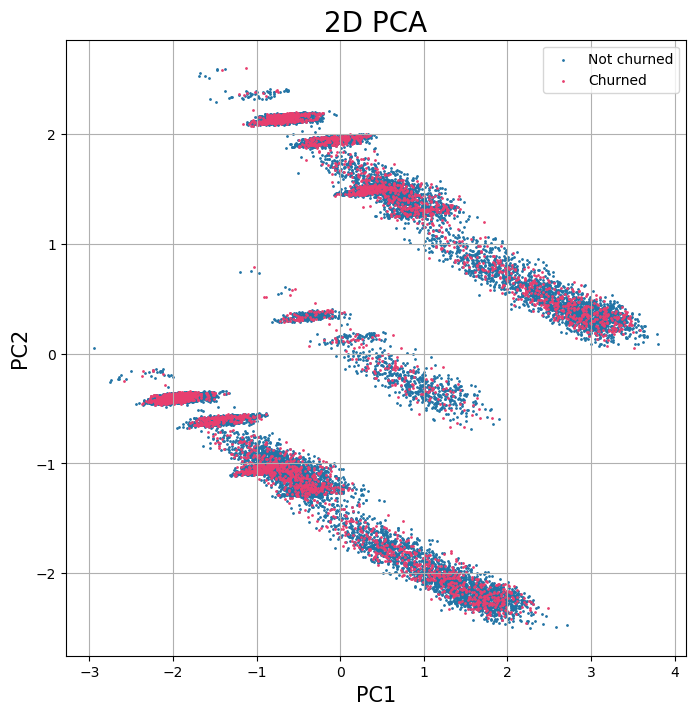

In [402]:
pca = PCA(n_components=2, random_state=seed)

principalComponents = pca.fit_transform(X)

principalDf2d = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

finalDf = pd.concat([principalDf2d, df[['Churned']]], axis = 1)
finalDf = finalDf.head(20000)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2D PCA', fontsize = 20)

targets = [0, 1]
colors = [not_churned_color, churned_color]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Churned'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 1)
ax.legend(["Not churned", "Churned"])
ax.grid()

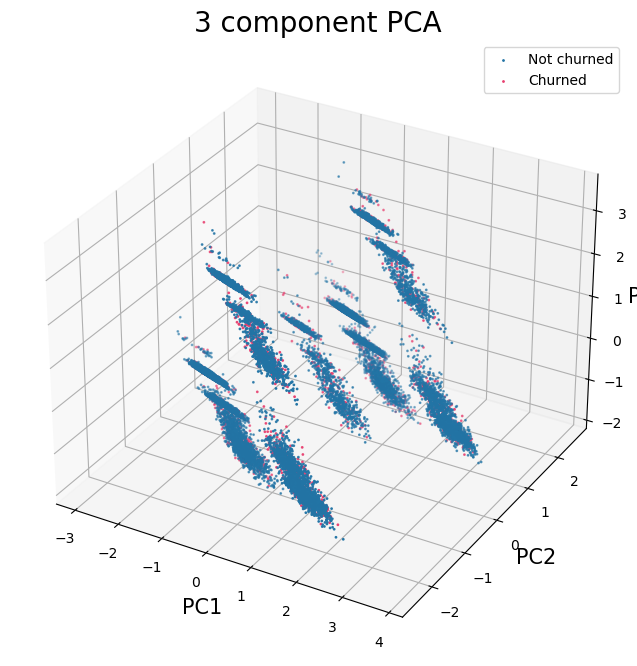

In [403]:
# Todo: show the churned values on top of not churned
pca = PCA(n_components=3, random_state=seed)


principalComponents = pca.fit_transform(X)

principalDf3d = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf3d, df[['Churned']]], axis = 1)
finalDf = finalDf.head(20000)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Churned'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2'], finalDf.loc[indicesToKeep, 'pc3']
               , c = color
               , s = 1)
ax.legend(["Not churned", "Churned"])
ax.grid()

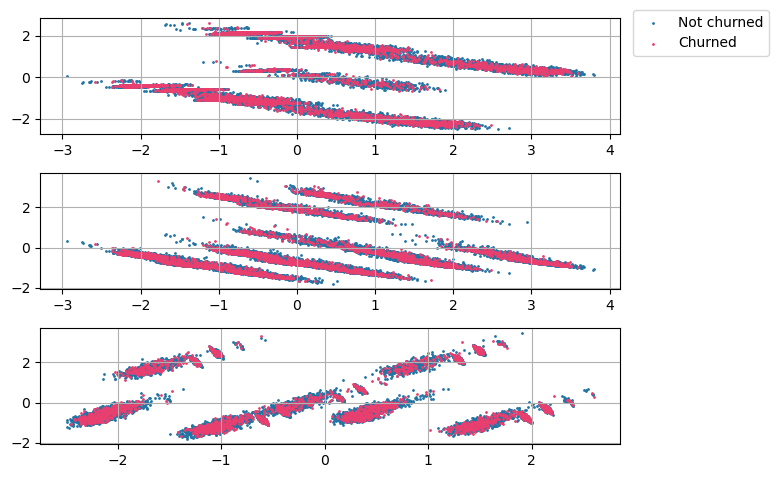

In [404]:
fig, ax = plt.subplots(3)
#ax.set_xlabel('PC1', fontsize = 15)
#ax.set_ylabel('PC2', fontsize = 15)
#ax.set_title('2D PCA', fontsize = 20)

comb = [("pc1", "pc2"),
       ("pc1", "pc3"),
       ("pc2", "pc3")]

for i, (pcx, pcy) in enumerate(comb):
    targets = [0, 1]
    colors = [not_churned_color, churned_color]
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Churned'] == target
        ax[i].scatter(finalDf.loc[indicesToKeep, pcx]
                   , finalDf.loc[indicesToKeep, pcy]
                   , c = color
                   , s = 1)
    ax[i].grid()
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#cax = plt.axes((0.85, 0.1, 0.075, 0.8))
#plt.colorbar(_i, cax=cax)
fig.legend(["Not churned", "Churned"], bbox_to_anchor=[1.22, 1])
fig.tight_layout()
plt.show()

Running model 'LGBM' training and prediction (1/8)
Running model 'LR' training and prediction (2/8)
Running model 'RF' training and prediction (3/8)
Running model 'GBC' training and prediction (4/8)
Running model 'MLP' training and prediction (5/8)
Running model 'ADA' training and prediction (6/8)
Running model 'KNC' training and prediction (7/8)
Running model 'LDA' training and prediction (8/8)
Epoch 1/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 4s 743us/step - accuracy: 0.7918 - loss: 0.4797
Epoch 2/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 4s 809us/step - accuracy: 0.8478 - loss: 0.3698
Epoch 3/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 3s 736us/step - accuracy: 0.8535 - loss: 0.3517
Epoch 4/4
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 3s 732us/step - accuracy: 0.8583 - loss: 0.3404
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step


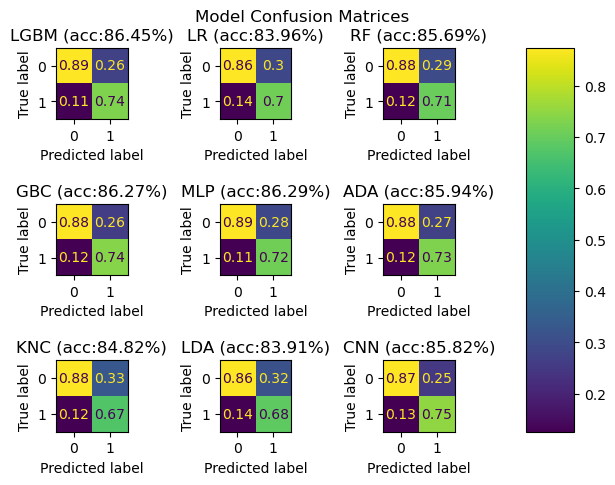

In [405]:

models = [("LGBM", LGBMClassifier(random_seed=seed, verbosity=-1)),
         ("LR", LogisticRegression(random_state=seed)),
         ("RF", RandomForestClassifier(random_state=seed)),
         ("GBC", GradientBoostingClassifier(random_state=seed)),
         ("MLP", MLPClassifier(random_state=seed)),
         ("ADA", AdaBoostClassifier(random_state=seed)),
         ("KNC", KNeighborsClassifier()),
         ("LDA", LinearDiscriminantAnalysis())]

cms = []

fig, axs = plt.subplots(3, 3)

plt.suptitle("Model Confusion Matrices")

for i, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    im = ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_predict, 
        normalize='pred', 
        ax=axs[i // 3, i % 3], 
        colorbar=False,
        
    )
    _i = im.im_
    axs[i // 3, i % 3].title.set_text(f"{name} (acc:{accuracy*100:.2f}%)")
    
    cms.append((name, cm))
    
    print(f"Running model '{name}' training and prediction ({i+1}/{len(models)})")

# CNN works by outputing two values (corresponding to confidence values for churned and not churned)
# so must be treated slightly differently to the other models:
    
y_ml_train = to_categorical(y_train)
y_ml_test = to_categorical(y_test)

epochs = 4
batch_size = 32

initialiser = keras.initializers.GlorotUniform(seed=seed)

cnn = Sequential()
cnn.add(Input((X_train.shape[1],)))
cnn.add(Dense(5, activation="sigmoid", kernel_initializer=initialiser))
cnn.add(Dense(5, activation="sigmoid", kernel_initializer=initialiser))
cnn.add(Dense(5, activation="sigmoid", kernel_initializer=initialiser))
cnn.add(Dense(2, activation="sigmoid", kernel_initializer=initialiser))

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

cnn.fit(X_train, y_ml_train, epochs=epochs, batch_size=batch_size)

y_predict = np.argmax(cnn.predict(X_test), axis=1)

accuracy = accuracy_score(y_test, y_predict)
im = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_predict, 
    normalize='pred', 
    ax=axs[2, 2], 
    colorbar=False,

)
_i = im.im_
axs[2, 2].title.set_text(f"CNN (acc:{accuracy*100:.2f}%)")
#axs[i // 3, i % 3].xlabel("")
#axs[i // 3, i % 3].ylabel.set_text("")

cms.append(("CNN", cm))

fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(_i, cax=cax)
plt.show()

1119/1119 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step


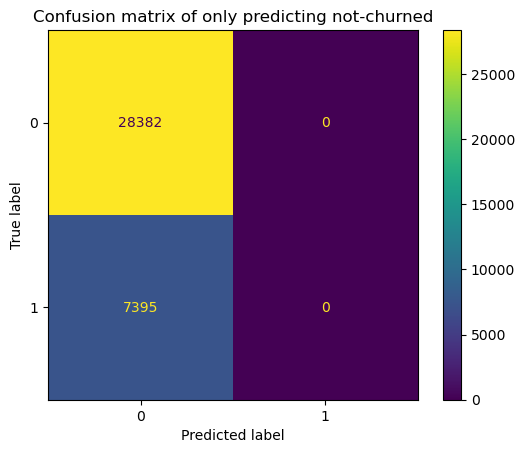

In [406]:
#A terrible CNN model that basically just guesses '0' and manages 79% accuracy because the dataset is 79% '0'.
trivial_model = keras.models.load_model('trivial_model.keras')

y_predict = np.argmax(trivial_model.predict(X_test), axis=1)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title("Confusion matrix of only predicting not-churned")
plt.show()

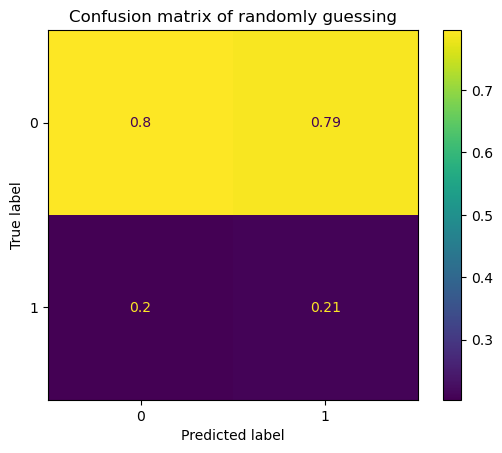

In [407]:
# Show what a confusion matrix looks like for model that just chooses values uniformly randomly
random_predictions = np.random.randint(2, size=y_test.shape[0])

ConfusionMatrixDisplay.from_predictions(y_test, random_predictions, normalize='pred')
plt.title("Confusion matrix of randomly guessing")
plt.show()